# Your First AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) from Oxford of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load the image dataset and create a pipeline.
* Build and Train an image classifier on this dataset.
* Use your trained model to perform inference on flower images.

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

## Install Datasets and Upgrade TensorFlow

To ensure we can download the latest version of the `oxford_flowers102` dataset, let's first install both `tensorflow-datasets` and `tfds-nightly`.
* `tensorflow-datasets` is the stable version that is released on a cadence of every few months
* `tfds-nightly` is released every day and has the latest version of the datasets

We'll also upgrade TensorFlow to ensure we have a version that is compatible with the latest version of the dataset.

In [1]:
%pip --no-cache-dir install tensorflow-datasets --user
%pip --no-cache-dir install tfds-nightly --user
%pip --no-cache-dir install --upgrade tensorflow --user

Note: you may need to restart the kernel to use updated packages.
     |████████████████████████████████| 4.3MB 4.7MB/s eta 0:00:01
     |████████████████████████████████| 102kB 35.7MB/s ta 0:00:01
     |████████████████████████████████| 409kB 42.6MB/s eta 0:00:01
ERROR: tensorflow-metadata 0.14.0 has requirement protobuf<4,>=3.7, but you'll have protobuf 4.21.1 which is incompatible.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
Note: you may need to restart the kernel to use updated packages.
     |████████████████████████████████| 511.7MB 26.9MB/s eta 0:00:01  |▎                               | 4.2MB 4.6MB/s eta 0:01:52     |█████████████████▎              | 276.0MB 35.9MB/s eta 0:00:07
     |████████████████████████████████| 4.4MB 31.3MB/s eta 0:00:01
     |████████████████████████████████| 1.1MB 24.5MB/s eta 0:00:01
     |████████████████████████████████| 440kB 37.9MB/s eta 0:00:01
     |████████████████████████

After the above installations have finished **be sure to restart the kernel**. You can do this by going to **Kernel > Restart**.

In [2]:
# Import TensorFlow 
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub

# Ignore some warnings that are not relevant (you can remove this if you prefer)
import warnings
warnings.filterwarnings('ignore')

In [3]:
# TODO: Make all other necessary imports.

import time
import numpy as np
import matplotlib.pyplot as plt
import json

import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [4]:
# Some other recommended settings:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
tfds.disable_progress_bar()

## Load the Dataset

Here you'll use `tensorflow_datasets` to load the [Oxford Flowers 102 dataset](https://www.tensorflow.org/datasets/catalog/oxford_flowers102). This dataset has 3 splits: `'train'`, `'test'`, and `'validation'`.  You'll also need to make sure the training data is normalized and resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet, but you'll still need to normalize and resize the images to the appropriate size.

In [5]:
# TODO: Load the dataset with TensorFlow Datasets. Hint: use tfds.load()

train_split = 60
test_val_split = 20

# splits = tfds.Split.ALL.subsplit([train_split, test_val_split, test_val_split])
#(training_set, validation_set, test_set), dataset_info = tfds.load('oxford_flowers102', split=splits, as_supervised=True, with_info=True)

dataset, dataset_info = tfds.load('oxford_flowers102', as_supervised=True, with_info=True)

# TODO: Create a training set, a validation set and a test set.
training_set, validation_set, test_set = dataset['train'], dataset['validation'], dataset['test']
# training_set, validation_set, test_set = dataset


In [6]:
# Check that dataset is a dictionary
print('dataset has type:', type(dataset))

# Print the keys of the dataset dictionary
print('\nThe keys of dataset are:', list(dataset.keys()))

dataset has type: <class 'dict'>

The keys of dataset are: ['train', 'test', 'validation']


In [7]:
# Display the dataset_info
dataset_info

tfds.core.DatasetInfo(
    name='oxford_flowers102',
    full_name='oxford_flowers102/2.1.1',
    description="""
    The Oxford Flowers 102 dataset is a consistent of 102 flower categories commonly occurring
    in the United Kingdom. Each class consists of between 40 and 258 images. The images have
    large scale, pose and light variations. In addition, there are categories that have large
    variations within the category and several very similar categories.
    
    The dataset is divided into a training set, a validation set and a test set.
    The training set and validation set each consist of 10 images per class (totalling 1020 images each).
    The test set consists of the remaining 6149 images (minimum 20 per class).
    
    Note: The dataset by default comes with a test size larger than the train
    size. For more info see this [issue](https://github.com/tensorflow/datasets/issues/3022).
    """,
    homepage='https://www.robots.ox.ac.uk/~vgg/data/flowers/102/',
    data

In [8]:
training_set

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [9]:
type(training_set)

tensorflow.python.data.ops.dataset_ops.PrefetchDataset

In [10]:
dataset_info.features['image']

Image(shape=(None, None, 3), dtype=tf.uint8)

In [11]:
dataset_info.features['label']

ClassLabel(shape=(), dtype=tf.int64, num_classes=102)

In [12]:
dataset_info.features['file_name']

Text(shape=(), dtype=tf.string)

In [13]:
dataset_info.splits['train']

<SplitInfo num_examples=1020, num_shards=1>

In [14]:
dataset_info.splits['validation']

<SplitInfo num_examples=1020, num_shards=1>

In [15]:
dataset_info.splits['test']

<SplitInfo num_examples=6149, num_shards=2>

## Explore the Dataset

In [16]:
# TODO: Get the number of examples in each set from the dataset info.

num_training_examples  = dataset_info.splits['train'].num_examples
num_validation_examples = dataset_info.splits['validation'].num_examples
num_test_examples = dataset_info.splits['test'].num_examples

total_num_examples = num_training_examples + num_validation_examples + num_test_examples

print('There are {:,} total images in the dataset'.format(total_num_examples))

print('\nThere are {:,} images in the training set'.format(num_training_examples))
print('There are {:,} images in the validation set'.format(num_validation_examples))
print('There are {:,} images in the test set'.format(num_test_examples))



# TODO: Get the number of classes in the dataset from the dataset info.
shape_images = dataset_info.features['image'].shape
num_classes = dataset_info.features['label'].num_classes

print('\nThe images in our dataset have shape:', shape_images)
print('There are {:,} classes in our dataset'.format(num_classes))


There are 8,189 total images in the dataset

There are 1,020 images in the training set
There are 1,020 images in the validation set
There are 6,149 images in the test set

The images in our dataset have shape: (None, None, 3)
There are 102 classes in our dataset


In [17]:
# TODO: Print the shape and corresponding label of 3 images in the training set.
for image, label in training_set.take(3):
    print('The images in the training set have:\n\u2022 shape:', image.shape, '\n\u2022 label:', label.numpy())

The images in the training set have:
• shape: (500, 667, 3) 
• label: 72
The images in the training set have:
• shape: (500, 666, 3) 
• label: 84
The images in the training set have:
• shape: (670, 500, 3) 
• label: 70


The label of this image is: 72


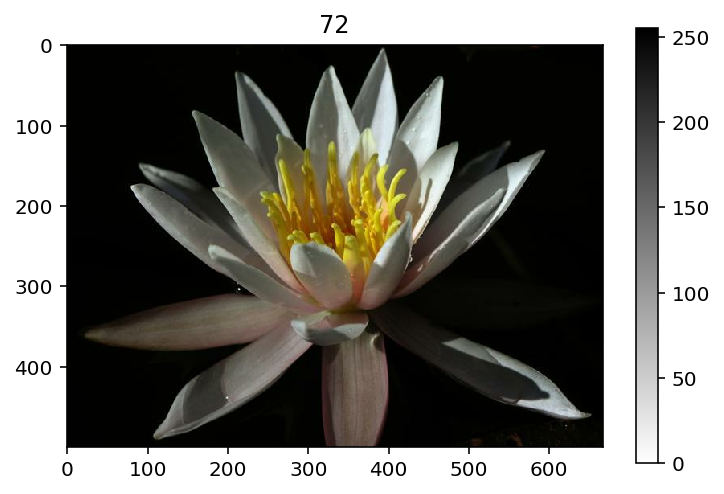

In [18]:
# TODO: Plot 1 image from the training set. 
for image, label in training_set.take(1):
    image = image.numpy().squeeze()
    label = label.numpy()

    
print('The label of this image is:', label)
# print('The class name of this image is:', class_names[label])

# Set the title of the plot to the corresponding image label. 
plt.imshow(image, cmap=plt.cm.binary)
plt.title(label) # tf.get_static_value(label)
plt.colorbar()
plt.show()

### Label Mapping

You'll also need to load in a mapping from label to category name. You can find this in the file `label_map.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/3.7/library/json.html). This will give you a dictionary mapping the integer coded labels to the actual names of the flowers.

In [19]:
with open('label_map.json', 'r') as f:
    class_names = json.load(f)

In [20]:
class_names

{'21': 'fire lily',
 '3': 'canterbury bells',
 '45': 'bolero deep blue',
 '1': 'pink primrose',
 '34': 'mexican aster',
 '27': 'prince of wales feathers',
 '7': 'moon orchid',
 '16': 'globe-flower',
 '25': 'grape hyacinth',
 '26': 'corn poppy',
 '79': 'toad lily',
 '39': 'siam tulip',
 '24': 'red ginger',
 '67': 'spring crocus',
 '35': 'alpine sea holly',
 '32': 'garden phlox',
 '10': 'globe thistle',
 '6': 'tiger lily',
 '93': 'ball moss',
 '33': 'love in the mist',
 '9': 'monkshood',
 '102': 'blackberry lily',
 '14': 'spear thistle',
 '19': 'balloon flower',
 '100': 'blanket flower',
 '13': 'king protea',
 '49': 'oxeye daisy',
 '15': 'yellow iris',
 '61': 'cautleya spicata',
 '31': 'carnation',
 '64': 'silverbush',
 '68': 'bearded iris',
 '63': 'black-eyed susan',
 '69': 'windflower',
 '62': 'japanese anemone',
 '20': 'giant white arum lily',
 '38': 'great masterwort',
 '4': 'sweet pea',
 '86': 'tree mallow',
 '101': 'trumpet creeper',
 '42': 'daffodil',
 '22': 'pincushion flower',
 

In [21]:
class_names['21']

'fire lily'

In [22]:
training_set.take(2)

<TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [23]:
# training_set
# public final class TakeDataset: Creates a dataset that contains `count` elements from the `input_dataset`.

The label of this image is: 48
The class name of this image is: buttercup


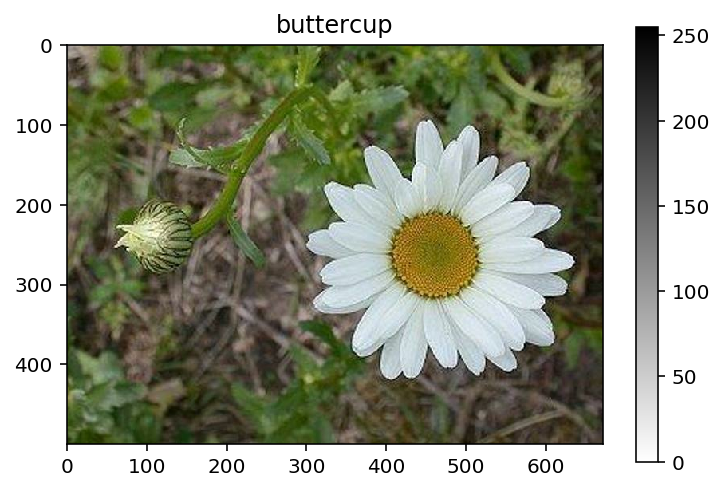

In [24]:
# TODO: Plot 1 image from the training set. Set the title 
# of the plot to the corresponding class name. 

for image, label in training_set.take(5):
    image = image.numpy().squeeze()
    label = label.numpy()
    # print(type(label))

    
print('The label of this image is:', label)
print('The class name of this image is:', class_names[label.astype(str)])

# Set the title of the plot to the corresponding image label. 
plt.imshow(image, cmap=plt.cm.binary)
plt.title(class_names[label.astype(str)]) # tf.get_static_value(label)
plt.colorbar()
plt.show()



## Create Pipeline


The pre-trained model we are going to use requires that the input images have color values in the range [0,1] and a size of **(224, 224)**. We will therefore have to normalize the pixel values of our images and resize them to the appropriate size. We can normalize our pixel values in the usual way by dividing the original pixel values by **255** and to resize our images we can use the `tf.image.resize()` function.


In [25]:
# TODO: Create a pipeline for each set.

batch_size = 32
image_size = 224

def format_image(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, (image_size, image_size))
    image /= 255
    return image, label


training_batches = training_set.cache().shuffle(num_training_examples//4).batch(batch_size).map(format_image).prefetch(1)
validation_batches = validation_set.cache().batch(batch_size).map(format_image).prefetch(1)
testing_batches = test_set.cache().batch(batch_size).map(format_image).prefetch(1)


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


# Build and Train the Classifier

Now that the data is ready, it's time to build and train the classifier. You should use the MobileNet pre-trained model from TensorFlow Hub to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. If you want to talk through it with someone, chat with your fellow students! 

Refer to the rubric for guidance on successfully completing this section. Things you'll need to do:

* Load the MobileNet pre-trained network from TensorFlow Hub.
* Define a new, untrained feed-forward network as a classifier.
* Train the classifier.
* Plot the loss and accuracy values achieved during training for the training and validation set.
* Save your trained model as a Keras model. 

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right.

**Note for Workspace users:** One important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to GPU Workspaces about Keeping Your Session Active. You'll want to include code from the workspace_utils.py module. Also, If your model is over 1 GB when saved as a checkpoint, there might be issues with saving backups in your workspace. If your saved checkpoint is larger than 1 GB (you can open a terminal and check with `ls -lh`), you should reduce the size of your hidden layers and train again.

In [26]:
# download the pre-trained MobileNet model without the final classification layer from TensorFlow Hub 
# using the hub.KerasLayer(URL) function.
# The pre-trained model will be responsible for extracting the features of our images, 
# we will therefore call this part of our model the feature_extractor.

#The shape of our input tensor must match the size of the images MobileNet was trained on, namely (224,224,3).
image_size = 224

URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

feature_extractor = hub.KerasLayer(URL, input_shape=(image_size, image_size,3))

Here I freeze the weights and biases in my pre-trained model so that I do not modify them during training. I do this by setting the parameters of my model to non-trainable, as shown in the code below.

In [27]:
feature_extractor.trainable = False

Here I create a tf.keras Sequential model with my `feature_extractor` and a new classification layer. Since the `oxford_flowers102` dataset has 102 flower categories, I create an output layer with **102** units.

In [28]:
# TODO: Build and train your network.

model = tf.keras.Sequential([
        feature_extractor,
        tf.keras.layers.Dense(102, activation = 'softmax')
])

model.summary()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 102)               130662    
                                                                 
Total params: 2,388,646
Trainable params: 130,662
Non-trainable params: 2,257,984
_________________________________________________________________


I use the `tf.test.is_gpu_available()` function to confirm that TensorFlow is using the GPU.

In [30]:
print('\t\u2022 Running on GPU' if tf.test.is_gpu_available() else '\t\u2022 GPU device not found. Running on CPU')

	• GPU device not found. Running on CPU


Before I train my model I set the parameters I am going to use to train it. I configure my model for training using the `.compile` method. 
I compile the model I created above using an `adam` optimizer, a `sparse_categorical_crossentropy` loss function since the `oxford_flowers102` dataset has integer type labels, and the `accuracy` metric. 

In [31]:
## Configure my model for training using the .compile method
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

EPOCHS = 10



Here I train the model I created above to classify different species of flower images in the `oxford_flowers102` dataset. Since I am using a pre-trained model, most likely I need only to train the model for a few epochs to get a high accuracy.

I also utilize a context manager called `active_session` that can be used to maintain an active session during long-running network training processes. 

In [34]:
import workspace_utils

In [35]:
from workspace_utils import active_session

with active_session():
    # do long-running training task here
    history = model.fit(training_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)
    

Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


InvalidArgumentError: Graph execution error:

Detected at node 'IteratorGetNext' defined at (most recent call last):
    File "/opt/conda/lib/python3.7/runpy.py", line 193, in _run_module_as_main
      "__main__", mod_spec)
    File "/opt/conda/lib/python3.7/runpy.py", line 85, in _run_code
      exec(code, run_globals)
    File "/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "/opt/conda/lib/python3.7/site-packages/traitlets/config/application.py", line 664, in launch_instance
      app.start()
    File "/opt/conda/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 563, in start
      self.io_loop.start()
    File "/opt/conda/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 132, in start
      self.asyncio_loop.run_forever()
    File "/opt/conda/lib/python3.7/asyncio/base_events.py", line 534, in run_forever
      self._run_once()
    File "/opt/conda/lib/python3.7/asyncio/base_events.py", line 1771, in _run_once
      handle._run()
    File "/opt/conda/lib/python3.7/asyncio/events.py", line 88, in _run
      self._context.run(self._callback, *self._args)
    File "/opt/conda/lib/python3.7/site-packages/tornado/ioloop.py", line 758, in _run_callback
      ret = callback()
    File "/opt/conda/lib/python3.7/site-packages/tornado/stack_context.py", line 300, in null_wrapper
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.7/site-packages/tornado/gen.py", line 1233, in inner
      self.run()
    File "/opt/conda/lib/python3.7/site-packages/tornado/gen.py", line 1147, in run
      yielded = self.gen.send(value)
    File "/opt/conda/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 361, in process_one
      yield gen.maybe_future(dispatch(*args))
    File "/opt/conda/lib/python3.7/site-packages/tornado/gen.py", line 326, in wrapper
      yielded = next(result)
    File "/opt/conda/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 268, in dispatch_shell
      yield gen.maybe_future(handler(stream, idents, msg))
    File "/opt/conda/lib/python3.7/site-packages/tornado/gen.py", line 326, in wrapper
      yielded = next(result)
    File "/opt/conda/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 541, in execute_request
      user_expressions, allow_stdin,
    File "/opt/conda/lib/python3.7/site-packages/tornado/gen.py", line 326, in wrapper
      yielded = next(result)
    File "/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 300, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "/opt/conda/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
      return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
    File "/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2848, in run_cell
      raw_cell, store_history, silent, shell_futures)
    File "/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2874, in _run_cell
      return runner(coro)
    File "/opt/conda/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
      coro.send(None)
    File "/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3051, in run_cell_async
      interactivity=interactivity, compiler=compiler, result=result)
    File "/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3242, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3319, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "<ipython-input-35-a9f3bcd20e41>", line 7, in <module>
      validation_data=validation_batches)
    File "/root/.local/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/root/.local/lib/python3.7/site-packages/keras/engine/training.py", line 1409, in fit
      tmp_logs = self.train_function(iterator)
    File "/root/.local/lib/python3.7/site-packages/keras/engine/training.py", line 1051, in train_function
      return step_function(self, iterator)
    File "/root/.local/lib/python3.7/site-packages/keras/engine/training.py", line 1039, in step_function
      data = next(iterator)
Node: 'IteratorGetNext'
Cannot batch tensors with different shapes in component 0. First element had shape [516,500,3] and element 8 had shape [500,750,3].
	 [[{{node IteratorGetNext}}]] [Op:__inference_train_function_17216]

In [ ]:
# TODO: Plot the loss and accuracy values achieved during training for the training and validation set.



## Testing your Network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [ ]:
# TODO: Print the loss and accuracy values achieved on the entire test set.



## Save the Model

Now that your network is trained, save the model so you can load it later for making inference. In the cell below save your model as a Keras model (*i.e.* save it as an HDF5 file).

In [ ]:
# TODO: Save your trained model as a Keras model.



## Load the Keras Model

Load the Keras model you saved above.

In [ ]:
# TODO: Load the Keras model



# Inference for Classification

Now you'll write a function that uses your trained network for inference. Write a function called `predict` that takes an image, a model, and then returns the top $K$ most likely class labels along with the probabilities. The function call should look like: 

```python
probs, classes = predict(image_path, model, top_k)
```

If `top_k=5` the output of the `predict` function should be something like this:

```python
probs, classes = predict(image_path, model, 5)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

Your `predict` function should use `PIL` to load the image from the given `image_path`. You can use the [Image.open](https://pillow.readthedocs.io/en/latest/reference/Image.html#PIL.Image.open) function to load the images. The `Image.open()` function returns an `Image` object. You can convert this `Image` object to a NumPy array by using the `np.asarray()` function.

The `predict` function will also need to handle pre-processing the input image such that it can be used by your model. We recommend you write a separate function called `process_image` that performs the pre-processing. You can then call the `process_image` function from the `predict` function. 

### Image Pre-processing

The `process_image` function should take in an image (in the form of a NumPy array) and return an image in the form of a NumPy array with shape `(224, 224, 3)`.

First, you should convert your image into a TensorFlow Tensor and then resize it to the appropriate size using `tf.image.resize`.

Second, the pixel values of the input images are typically encoded as integers in the range 0-255, but the model expects the pixel values to be floats in the range 0-1. Therefore, you'll also need to normalize the pixel values. 

Finally, convert your image back to a NumPy array using the `.numpy()` method.

In [ ]:
# TODO: Create the process_image function



To check your `process_image` function we have provided 4 images in the `./test_images/` folder:

* cautleya_spicata.jpg
* hard-leaved_pocket_orchid.jpg
* orange_dahlia.jpg
* wild_pansy.jpg

The code below loads one of the above images using `PIL` and plots the original image alongside the image produced by your `process_image` function. If your `process_image` function works, the plotted image should be the correct size. 

In [ ]:
from PIL import Image

image_path = './test_images/hard-leaved_pocket_orchid.jpg'
im = Image.open(image_path)
test_image = np.asarray(im)

processed_test_image = process_image(test_image)

fig, (ax1, ax2) = plt.subplots(figsize=(10,10), ncols=2)
ax1.imshow(test_image)
ax1.set_title('Original Image')
ax2.imshow(processed_test_image)
ax2.set_title('Processed Image')
plt.tight_layout()
plt.show()

Once you can get images in the correct format, it's time to write the `predict` function for making inference with your model.

### Inference

Remember, the `predict` function should take an image, a model, and then returns the top $K$ most likely class labels along with the probabilities. The function call should look like: 

```python
probs, classes = predict(image_path, model, top_k)
```

If `top_k=5` the output of the `predict` function should be something like this:

```python
probs, classes = predict(image_path, model, 5)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

Your `predict` function should use `PIL` to load the image from the given `image_path`. You can use the [Image.open](https://pillow.readthedocs.io/en/latest/reference/Image.html#PIL.Image.open) function to load the images. The `Image.open()` function returns an `Image` object. You can convert this `Image` object to a NumPy array by using the `np.asarray()` function.

**Note:** The image returned by the `process_image` function is a NumPy array with shape `(224, 224, 3)` but the model expects the input images to be of shape `(1, 224, 224, 3)`. This extra dimension represents the batch size. We suggest you use the `np.expand_dims()` function to add the extra dimension. 

In [ ]:
# TODO: Create the predict function



# Sanity Check

It's always good to check the predictions made by your model to make sure they are correct. To check your predictions we have provided 4 images in the `./test_images/` folder:

* cautleya_spicata.jpg
* hard-leaved_pocket_orchid.jpg
* orange_dahlia.jpg
* wild_pansy.jpg

In the cell below use `matplotlib` to plot the input image alongside the probabilities for the top 5 classes predicted by your model. Plot the probabilities as a bar graph. The plot should look like this:

<img src='assets/inference_example.png' width=600px>

You can convert from the class integer labels to actual flower names using `class_names`. 

In [ ]:
# TODO: Plot the input image along with the top 5 classes
